In [1]:
from os.path import join
import pyelsa as elsa
import aomip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mig
import utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import signal
from GradientDescent import gradient_descent
import sympy
from skimage.transform import radon, rescale

pyelsa not build with CUDA projector support


In [ ]:
## Prepare data
local=True

##local
if local:
    data_path = 'Walnut2/Projections/tubeV1'
else:
    data_path = '/srv/ceph/share-all/aomip/Walnut1/Projections/tubeV1'
projs_name = 'scan_{:06}.tif'
dark_name = 'di000000.tif'
flat_name = ['io000000.tif', 'io000001.tif']
vecs_name = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# load the numpy array describing the scan geometry from file
# vecs = np.loadtxt(join(data_path, vecs_name))
# get the positions we need; there are in fact 1201, but the last and first one come from the same angle
# vecs       = vecs[range(0,1200, 1)]
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision
projs_idx  = range(1200,0, -1)

num_projections = 1200 #vecs.shape[0]

# create the numpy array which will receive projection data from tiff files
projs = np.zeros((num_projections, projs_rows, projs_cols), dtype=np.float32)

# Changing orientation from landscape to portrait mode
trafo = lambda image : np.transpose(np.flipud(image))

# load flat-field and dark-fields
# there are two flat-field images (taken before and after acquisition), we simply average them
dark = trafo(plt.imread(join(data_path, dark_name)))
flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)

# Combine avereate of the flat field image
for i, fn in enumerate(flat_name):
    flat[i] = trafo(plt.imread(join(data_path, fn)))
flat =  np.mean(flat,axis=0)

# load projection data
for i in range(num_projections):
    projs[i] = trafo(plt.imread(join(data_path, projs_name.format(projs_idx[i]))))

# Homework 1: Preprocessing again

To show how extracting different rows of a projection image and stacking them resulting in a different sinogram, and how the results of these sinograms affect the reconstruction in the future steps, 5 sinograms images are generated. Since a projection image contains 972 rows, upper, middle and lower rows are selected to produce the sinogram to show a greater range of contrasts. Hence, row 50, 100, 200, 400, 800 are from extracted from each projection of the overall 1200 projection images. Then, the extracted row is stacked with the subsequent projection image in which the same row is also extracted. This process is repeated until all rows of the 1200 projection images are fully stacked. Hence, the sliced sinogram will be a 2D array of shape (1200,768) as the original projection image is (972,768).

In [ ]:
slice_idx_50 = 50
slice_idx_100 = 100
slice_idx_200 = 200
slice_idx_400 = 400
slice_idx_800 = 800

sliced_sinogram_50 = np.empty((num_projections, projs_cols), dtype=np.float32)
sliced_sinogram_100 = np.empty((num_projections, projs_cols), dtype=np.float32)
sliced_sinogram_200 = np.empty((num_projections, projs_cols), dtype=np.float32)
sliced_sinogram_400 = np.empty((num_projections, projs_cols), dtype=np.float32)
sliced_sinogram_800 = np.empty((num_projections, projs_cols), dtype=np.float32)

for i in range(num_projections):
    proj=projs[i]
    row_50 = proj[slice_idx_50, :]
    sliced_sinogram_50[i, :] = row_50
    row_100 = proj[slice_idx_100, :]
    sliced_sinogram_100[i, :] = row_100
    row_200 = proj[slice_idx_200, :]
    sliced_sinogram_200[i, :] = row_200
    row_400 = proj[slice_idx_400, :]
    sliced_sinogram_400[i, :] = row_400
    row_800 = proj[slice_idx_800, :]
    sliced_sinogram_800[i, :] = row_800

utils.save_array_as_image(sliced_sinogram_50,'sliced_sinogram_50.png','Img')
utils.save_array_as_image(sliced_sinogram_100,'sliced_sinogram_100.png','Img')
utils.save_array_as_image(sliced_sinogram_200,'sliced_sinogram_200.png','Img')
utils.save_array_as_image(sliced_sinogram_400,'sliced_sinogram_400.png','Img')
utils.save_array_as_image(sliced_sinogram_800,'sliced_sinogram_800.png','Img')

In [ ]:
plt.imshow(sliced_sinogram_200)

# Homework 2: Iterative Reconstruction

Minimum of 2D function: [0.499995586412842]
Stop at iteration: 62


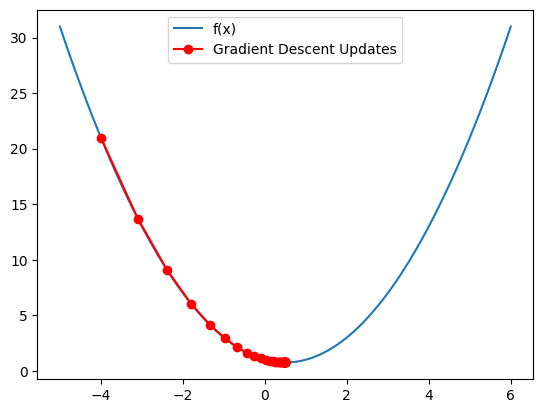

In [4]:
x, y = sympy.symbols('x y')

f1d = x**2 - x + 1
f2d = x**2 + y**2

# Find minimum of 2D function using gradient descent
x0 = np.array([-4])
x_min, x_hist, stpIdx = gradient_descent(f1d, [x], x0)
print('Minimum of 2D function:', x_min)
print('Stop at iteration:', stpIdx)

f_history = np.array([f1d.subs(x, x_val[0]) for x_val in x_hist], dtype=float)
x_vals = np.linspace(-5, 6, 100)
f_vals = np.array([f1d.subs(x, x_val).evalf() for x_val in x_vals])
plt.plot(x_vals, f_vals, label='f(x)')
plt.plot(x_hist, f_history, 'ro-', label='Gradient Descent Updates')
plt.legend()
plt.show()


Minimum of 2D function: [-3.13855086769334e-6, -3.13855086769334e-6]
Stop at iteration: 63


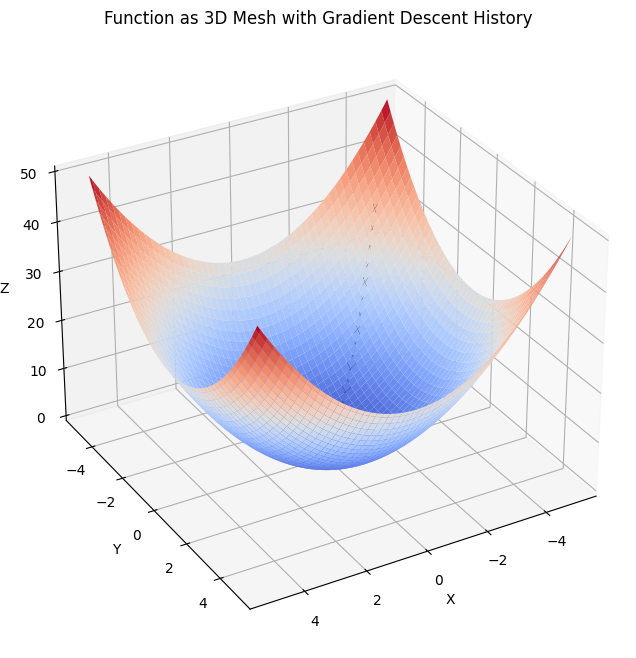

In [5]:
# Find minimum of 2D function using gradient descent
x0 = np.array([-4, -4])
x_min, x_hist, stpIdx = gradient_descent(f2d, [x,y], x0)
print('Minimum of 2D function:', x_min)
print('Stop at iteration:', stpIdx)

# Create a meshgrid for the x and y values
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[f2d.subs([(x, i), (y, j)]) for i in x_vals] for j in y_vals])
Z_history = np.array([f2d.subs([(x, row[0]), (y, row[1])]).evalf() for row in x_hist], dtype=float)

# Plot the function as a 3D mesh
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Function as 3D Mesh with Gradient Descent History')
ax.view_init(30, 60)
ax.plot(x_hist[:, 0], x_hist[:, 1], Z_history, color='black', marker='o')
plt.show()
fig.savefig("2D_GD_update_history_3Dmesh_v2.png")